In [2]:
# Imports

# Gymnasium
# -----------------------
import gymnasium as gym
from gymnasium import spaces
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import numpy as np

# -----------------------
# Stable Baselines 3
# -----------------------
import optuna
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from qlearning import tabular_q_learning

In [ ]:
import gymnasium as gym
import numpy as np
import gymnasium as gym
import numpy as np
from gymnasium.spaces import Discrete

# -----------------------------------------------------------
# Discretized Action Wrapper
# -----------------------------------------------------------
class DiscretizedActionWrapper(gym.ActionWrapper):
    """
    Converts a continuous one-dimensional action space (Box) into a discrete one by mapping 
    discrete indices to equally spaced continuous actions.
    """
    def __init__(self, env, n_bins=5):
        super().__init__(env)
        self.n_bins = n_bins
        
        # Assume the original action space is a one-dimensional Box.
        assert isinstance(self.action_space, gym.spaces.Box), "This wrapper only supports Box action spaces."
        self.low = env.action_space.low[0]
        self.high = env.action_space.high[0]
        
        # Define a new discrete action space.
        self.action_space = Discrete(n_bins)
        
        # Precompute the mapping from discrete index to continuous action.
        self.discrete_actions = np.linspace(self.low, self.high, n_bins)
    
    def action(self, action):
        # Map the discrete action (an integer) to its corresponding continuous value.
        return np.array([self.discrete_actions[action]])
    

# -----------------------------------------------------------
# Flatten Discrete Observation Wrapper
# -----------------------------------------------------------
class FlattenDiscreteObservationWrapper(gym.ObservationWrapper):
    """
    Discretizes each component of a continuous (Box) observation into n_bins,
    then encodes the resulting vector as a single integer.
    
    The encoding is done via a base conversion where each dimension's discrete 
    value is treated as a digit in base n_bins.
    
    The new observation_space becomes a Discrete space with n_bins**d states,
    where d is the number of dimensions in the original observation.
    """
    def __init__(self, env, n_bins=10):
        super().__init__(env)
        self.n_bins = n_bins
        
        # Ensure that the original observation space is a Box.
        assert isinstance(self.observation_space, gym.spaces.Box), "This wrapper only supports Box observation spaces."
        
        # Number of dimensions in the observation.
        self.obs_dim = self.observation_space.shape[0]
        
        # Create bin boundaries for each dimension.
        # For each dimension, create n_bins+1 equally spaced boundaries and then remove the first and last edge.
        self.bins = []
        for low, high in zip(self.observation_space.low, self.observation_space.high):
            # This creates n_bins-1 bin boundaries so that np.digitize returns values in {0,..., n_bins-1}.
            bins = np.linspace(low, high, n_bins + 1)[1:-1]
            self.bins.append(bins)
        
        # Replace the observation space with a flattened discrete space.
        total_states = n_bins ** self.obs_dim
        self.observation_space = Discrete(total_states)
    
    def observation(self, obs):
        # Digitize each component of the observation.
        discrete_vals = [int(np.digitize(obs[i], self.bins[i])) for i in range(self.obs_dim)]
        
        # Encode the multi-dimensional discrete vector as a single integer.
        # We use a simple base conversion: state_id = sum_{i=0}^{d-1} discrete_vals[i] * (n_bins ** i)
        state_id = 0
        for i, val in enumerate(discrete_vals):
            state_id += val * (self.n_bins ** i)
        return state_id
    


# -----------------------------------------------------------
# Create the Tabular Q-Learning Environment
# -----------------------------------------------------------
def make_tabular_env(obs_bins=10, act_bins=5):
    """
    Creates a tabular Q-learning friendly environment from the continuous
    Pendulum-v1 environment by discretizing (and flattening) the observations and actions.
    """
    env = gym.make("Pendulum-v1")
    # Apply the observation wrapper to get a single discrete state.
    env = FlattenDiscreteObservationWrapper(env, n_bins=obs_bins)
    # Apply the action wrapper to get a discrete action space.
    env = DiscretizedActionWrapper(env, n_bins=act_bins)
    return RecordEpisodeStatistics(env)

# -----------------------------------------------------------
# Example Usage
# -----------------------------------------------------------
if __name__ == "__main__":
    # Create the environment with 10 bins per observation dimension and 5 discrete actions.
    env = make_tabular_env(obs_bins=10, act_bins=5)
    
    # Reset the environment.
    obs, info = env.reset()
    print("Flattened discrete observation (state id):", obs)
    print("Observation space:", env.observation_space)
    print("Action space:", env.action_space)
    
    # Run a few steps with random actions.
    for step in range(5):
        action = env.action_space.sample()  # A discrete integer from 0 to (act_bins-1)
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"Step {step}: Action {action} -> New state id: {obs}, Reward: {reward}")



Flattened discrete observation (state id): 520
Observation space: Discrete(1000)
Action space: Discrete(5)
Step 0: Action 3 -> New state id: 520, Reward: -6.985485569773562
Step 1: Action 0 -> New state id: 420, Reward: -6.847872173499603
Step 2: Action 0 -> New state id: 420, Reward: -6.8944299933059705
Step 3: Action 2 -> New state id: 430, Reward: -7.206023301780998
Step 4: Action 4 -> New state id: 430, Reward: -7.6196877875818245


In [12]:
# # ----- Environment Setup for DQN (requires discrete actions) -----
# # Create the original Pendulum environment
# env_dqn = gym.make("Pendulum-v1")
# # Wrap it so that actions are discretized (e.g., 5 bins)
# env_dqn = DiscretizedActionWrapper(env_dqn, n_bins=5)
# # Vectorize the environment (even one environment works fine)
# env_dqn = make_vec_env(lambda: env_dqn, n_envs=1)

# # ----- Train DQN Agent -----
# dqn_model = DQN("MlpPolicy", env_dqn, verbose=1)
# print("Training DQN on discretized Pendulum-v1...")
# dqn_model.learn(total_timesteps=1000)
# dqn_model.save("dqn_pendulum")
# print("DQN training complete and model saved as 'dqn_pendulum.zip'.")

# # ----- Environment Setup for A2C -----
# # A2C supports continuous actions directly.
# env_a2c = gym.make("Pendulum-v1")
# env_a2c = make_vec_env(lambda: env_a2c, n_envs=1)

# # ----- Train A2C Agent -----
# a2c_model = A2C("MlpPolicy", env_a2c, verbose=1)
# print("Training A2C on continuous Pendulum-v1...")
# a2c_model.learn(total_timesteps=1000)
# a2c_model.save("a2c_pendulum")
# print("A2C training complete and model saved as 'a2c_pendulum.zip'.")


In [13]:
import gymnasium as gym
import numpy as np
from gymnasium.spaces import MultiDiscrete

class DiscretizeObservationWrapper(gym.ObservationWrapper):
    """
    Discretizes continuous observations into discrete bins for each dimension.
    
    For each dimension of the original observation (assumed to be a Box),
    this wrapper creates bins and maps the continuous value into a discrete
    bin index (0 to n_bins-1). The new observation space is defined as a
    MultiDiscrete space.
    """
    def __init__(self, env, n_bins=10):
        super(DiscretizeObservationWrapper, self).__init__(env)
        self.n_bins = n_bins
        
        # Ensure the observation space is of type Box
        assert isinstance(self.observation_space, gym.spaces.Box), "Only Box observation spaces are supported"
        
        # Create bins for each dimension based on the low/high bounds.
        self.bins = []
        for low, high in zip(self.observation_space.low, self.observation_space.high):
            # Create n_bins equally spaced bin boundaries (excluding the endpoints)
            bins = np.linspace(low, high, n_bins + 1)[1:-1]
            self.bins.append(bins)
        
        # Update the observation space to a MultiDiscrete with one discrete variable per dimension.
        self.observation_space = MultiDiscrete([n_bins] * self.observation_space.shape[0])
    
    def observation(self, obs):
        # Digitize each component of the observation using its corresponding bins.
        discrete_obs = [int(np.digitize(obs[i], self.bins[i])) for i in range(len(obs))]
        return np.array(discrete_obs)
    




In [78]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor


def make_tabular_env(obs_bins=10, act_bins=5):
    """
    Creates a tabular Q-learning friendly environment from the continuous
    Pendulum-v1 environment by discretizing both observations and actions.
    """
    env = gym.make("Pendulum-v1", max_episode_steps=100)
    env = FlattenDiscreteObservationWrapper(env, n_bins=obs_bins)
    env = DiscretizedActionWrapper(env, n_bins=act_bins)
    return Monitor(env, filename='tabular q')

def make_dqn_env(act_bins=5):
    """
    Creates a tabular Q-learning friendly environment from the continuous
    Pendulum-v1 environment by discretizing both observations and actions.
    """
    env = gym.make("Pendulum-v1", max_episode_steps=100)
    env = DiscretizedActionWrapper(env, n_bins=act_bins)
    return Monitor(env, filename='dqn')



def make_a2c_env():
    env = gym.make("Pendulum-v1", max_episode_steps=100)
    return Monitor(env, filename='a2c')


In [15]:
env = make_tabular_env(obs_bins=10, act_bins=5)
tabular_q_learning(env, total_episodes=100)

Episode 100: Total Reward = -593.1756722048077


(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-2.53178052, -1.14458384, -4.1884152 , -2.39131803, -2.57444891],
        ...,
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
 [-649.598825073777,
  -500.43065993602374,
  -567.9234154059596,
  -789.0180171795557,
  -730.8250873098718,
  -628.0287525785052,
  -787.1026171688097,
  -717.2652486334367,
  -745.6168609469289,
  -490.0999712684304,
  -724.6988767947198,
  -447.05423506827344,
  -816.2629275173845,
  -467.42020575576356,
  -497.59156305601743,
  -589.6581087434711,
  -645.041541567831,
  -682.793305074523,
  -774.9933907288521,
  -521.0527863119582,
  -571.7980877548805,
  -578.6365902440971,
  -392.5069483555538,
  -631.675711395473,
  -497.

In [16]:
# 1. Tabular q-learning objective
def tabular_q_learning_objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    gamma = trial.suggest_float("gamma", 0.9, 1)
    epsilon = trial.suggest_float("epsilon", 0.01, 1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.01, 1)
    obs_bins = trial.suggest_categorical('obs_bins', [10, 20, 50])
    act_bins = trial.suggest_categorical('act_bins', [10, 20, 50])

    total_timesteps = 5000  # Use a smaller budget for tuning

    env = make_tabular_env(obs_bins, act_bins)
    # Run Q-learning for num_episodes episodes
    Q, total_rewards = tabular_q_learning(env, total_episodes=total_timesteps // 100, learning_rate=learning_rate, gamma=gamma, epsilon=epsilon)
    
    # Return the average reward (since we want to maximize reward)
    return np.mean(total_rewards)

# 2. DQN objective using Stable-Baselines3.
def objective_dqn(trial):
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    gamma = trial.suggest_uniform('gamma', 0.90, 0.999)
    buffer_size = trial.suggest_categorical('buffer_size', [50000, 100000, 200000])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    exploration_fraction = trial.suggest_uniform('exploration_fraction', 0.1, 0.5)
    exploration_final_eps = trial.suggest_uniform('exploration_final_eps', 0.01, 0.1)
    target_update_interval = trial.suggest_categorical('target_update_interval', [100, 500, 1000])
    n_bins = trial.suggest_categorical('n_bins', [10, 20, 40])
    
    env = gym.make("Pendulum-v1")
    # Wrap the environment so that its action space is discretized.
    env = DiscretizedActionWrapper(env, n_bins=n_bins)
    model = DQN("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma,
                buffer_size=buffer_size, batch_size=batch_size,
                exploration_fraction=exploration_fraction, exploration_final_eps=exploration_final_eps,
                target_update_interval=target_update_interval, verbose=0)
    # Train for a limited number of timesteps.
    model.learn(total_timesteps=5000)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

# 3. A2C objective using Stable-Baselines3.
def objective_a2c(trial):
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    gamma = trial.suggest_uniform('gamma', 0.90, 0.999)
    n_steps = trial.suggest_categorical('n_steps', [5, 10, 20, 50])
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1e-2)
    vf_coef = trial.suggest_uniform('vf_coef', 0.1, 1.0)
    max_grad_norm = trial.suggest_uniform('max_grad_norm', 0.5, 1.0)
    
    env = gym.make("Pendulum-v1")
    model = A2C("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma, n_steps=n_steps,
                ent_coef=ent_coef, vf_coef=vf_coef, max_grad_norm=max_grad_norm, verbose=0)
    model.learn(total_timesteps=5000)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

study_tabular = optuna.create_study(direction="maximize")
study_tabular.optimize(tabular_q_learning_objective, n_trials=1)
print("Best hyperparameters for Tabular Q-learning:", study_tabular.best_trial.params)

# Tune DQN.
study_dqn = optuna.create_study(direction="maximize")
study_dqn.optimize(objective_dqn, n_trials=1)
print("Best hyperparameters for DQN:", study_dqn.best_trial.params)

# Tune A2C.
study_a2c = optuna.create_study(direction="maximize")
study_a2c.optimize(objective_a2c, n_trials=1)
print("Best hyperparameters for A2C:", study_a2c.best_trial.params)


[I 2025-02-26 10:21:45,871] A new study created in memory with name: no-name-6f1f5396-b08f-4653-9147-cef43db943cd
C:\Users\AcerC\AppData\Local\Temp\ipykernel_16588\451884999.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
[I 2025-02-26 10:21:46,067] Trial 0 finished with value: -668.7993497194029 and parameters: {'learning_rate': 0.0023193201993357573, 'gamma': 0.9069948251725083, 'epsilon': 0.28553727099410753, 'epsilon_decay': 0.9199362827169222, 'obs_bins': 50, 'act_bins': 20}. Best is trial 0 with value: -668.7993497194029.
[I 2025-02-26 10:21:46,068] A new study created in memory with name: no-name-86b99ea3-2890-4d85-b439-caf182d964ba


Best hyperparameters for Tabular Q-learning: {'learning_rate': 0.0023193201993357573, 'gamma': 0.9069948251725083, 'epsilon': 0.28553727099410753, 'epsilon_decay': 0.9199362827169222, 'obs_bins': 50, 'act_bins': 20}


C:\Users\AcerC\AppData\Local\Temp\ipykernel_16588\451884999.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-3)
C:\Users\AcerC\AppData\Local\Temp\ipykernel_16588\451884999.py:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.90, 0.999)
C:\Users\AcerC\AppData\Local\Temp\ipykernel_16588\451884999.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  exploration_fraction = trial.suggest_uniform('exploration_fraction', 0.1, 0.5)
C:\Users\AcerC\AppData\L

Best hyperparameters for DQN: {'lr': 0.0005396657664458981, 'gamma': 0.9427764258306951, 'buffer_size': 50000, 'batch_size': 128, 'exploration_fraction': 0.36279661258486906, 'exploration_final_eps': 0.09762823588829822, 'target_update_interval': 1000, 'n_bins': 10}


[I 2025-02-26 10:22:03,862] Trial 0 finished with value: -1490.5919573664664 and parameters: {'lr': 0.00015029288685743726, 'gamma': 0.9666277655639753, 'n_steps': 5, 'ent_coef': 0.00013912081869479776, 'vf_coef': 0.5006272338778477, 'max_grad_norm': 0.6210976710551603}. Best is trial 0 with value: -1490.5919573664664.


Best hyperparameters for A2C: {'lr': 0.00015029288685743726, 'gamma': 0.9666277655639753, 'n_steps': 5, 'ent_coef': 0.00013912081869479776, 'vf_coef': 0.5006272338778477, 'max_grad_norm': 0.6210976710551603}


In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Import RL algorithms from Stable-Baselines3
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# ========================================================
# STEP 3: BASELINE PERFORMANCE COMPARISON SETUP
# ========================================================
# We assume the water supply environment ("YourWaterSupplyEnv-v0")
# is registered with Gymnasium and uses discrete observation/action spaces.
# We also assume that the tabular Q-learning implementation (q_learning function)
# and the optimal hyperparameters for each algorithm have already been obtained.

# --- (1) Define the experiment runners for each agent type ---
# Each function runs the corresponding algorithm for a fixed training duration,
# evaluates performance on evaluation episodes, and returns the evaluation score.

# (a) Tabular Q-Learning Experiment Runner
def run_tabular_q_learning(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the tabular Q-learning experiment with given seed and hyperparameters.
    
    optimal_params: dict with keys 'alpha', 'gamma', 'epsilon', and 'num_episodes'
    Returns: Average reward over evaluation episodes.
    """
    np.random.seed(seed)
    env = make_tabular_env(obs_bins=optimal_params['obs_bins'], act_bins=optimal_params['act_bins'])
    # Set the environment seed (if supported by your environment)
    env.reset(seed=seed)
    
    # Run our previously defined Q-learning algorithm.
    Q, rewards_all = tabular_q_learning(env,
                                total_episodes=total_timesteps // 100,
                                learning_rate=optimal_params['learning_rate'],
                                gamma=optimal_params['gamma'],
                                epsilon=optimal_params['epsilon'],
                                epsilon_decay=optimal_params['epsilon_decay'])
    
    # Evaluate the learned Q-table:
    # Here we use a simple evaluation function: run a few episodes with a greedy policy.
    eval_rewards = []
    num_eval_episodes = n_eval_episodes
    for _ in range(num_eval_episodes):
        state, info = env.reset(seed=seed)
        done = False
        truncated = False
        total_reward = 0
        while not done and not truncated:
            # Greedy action selection based on Q-table.
            action = int(np.argmax(Q[state]))
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
        eval_rewards.append(total_reward)
    training_times = env.get_episode_times()
    return eval_rewards, [rewards_all], training_times, Q, env

# (b) DQN Experiment Runner using Stable-Baselines3
def run_dqn(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the DQN experiment with the given seed and hyperparameters.
    
    optimal_params: dict with keys such as 'learning_rate', 'gamma', etc.
    Returns: Mean reward over evaluation episodes.
    """
    env = make_dqn_env(optimal_params['n_bins'])
    env.reset(seed=seed)
    model = DQN("MlpPolicy", env,
                learning_rate=optimal_params['lr'],
                gamma=optimal_params['gamma'],
                buffer_size=optimal_params['buffer_size'],
                batch_size=optimal_params['batch_size'],
                exploration_fraction=optimal_params['exploration_fraction'],
                exploration_final_eps=optimal_params['exploration_final_eps'],
                target_update_interval=optimal_params['target_update_interval'],
                seed=seed,
                verbose=0,
                device='cpu')
    # Train model for a fixed number of timesteps.
    model.learn(total_timesteps=total_timesteps, progress_bar=True)
    eval_rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    training_rewards = env.get_episode_rewards()
    training_times = env.get_episode_times()
    return eval_rewards, [training_rewards], training_times, model, env

# (c) A2C Experiment Runner using Stable-Baselines3
def run_a2c(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the A2C experiment with the given seed and hyperparameters.
    
    optimal_params: dict with keys such as 'lr', 'gamma', 'n_steps', etc.
    Returns: Mean reward over evaluation episodes.
    """
    env = make_a2c_env()
    env.reset(seed=seed)
    model = A2C("MlpPolicy", env,
                learning_rate=optimal_params['lr'],
                gamma=optimal_params['gamma'],
                n_steps=optimal_params['n_steps'],
                ent_coef=optimal_params['ent_coef'],
                vf_coef=optimal_params['vf_coef'],
                max_grad_norm=optimal_params['max_grad_norm'],
                seed=seed,
                verbose=0,
                device='cpu')
    model.learn(total_timesteps=total_timesteps, progress_bar=True)
    eval_rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    training_rewards = env.get_episode_rewards()
    training_times = env.get_episode_times()
    return eval_rewards, [training_rewards], training_times, model, env

# ========================================================
# (2) Run Experiments Across Multiple Seeds for Each Agent
# ========================================================
# Define a list of seeds for reproducibility.
seeds = [0, 1]

# Assume these optimal hyperparameters have been determined from Step 2.
optimal_params_tabular = study_tabular.best_trial.params

optimal_params_dqn = study_dqn.best_trial.params

optimal_params_a2c = study_a2c.best_trial.params

# Containers for results: a dictionary mapping algorithm name to list of evaluation rewards.
results = {
    "Tabular_Q": [],
    "DQN": [],
    "A2C": []
}

learning_curves = {"Tabular_Q": [],
                   "DQN": [],
                   "A2C": []}
training_times = {"Tabular_Q": [],
                  "DQN": [],
                  "A2C": []}



# Run experiments for each seed.
for seed in seeds:
    print(f"Running experiment with seed: {seed}")
    
    # Run Tabular Q-learning.
    reward_tabular, tabular_learning_curve, tabular_training_times, Q, tabular_env = run_tabular_q_learning(seed, optimal_params_tabular, total_timesteps=50000)
    results["Tabular_Q"].append(reward_tabular)
    learning_curves['Tabular_Q'].append(np.array(tabular_learning_curve))
    training_times['Tabular_Q'].append(tabular_training_times)
    print(f"Tabular Q-learning (seed {seed}): {reward_tabular}")
    
    # Run DQN.
    reward_dqn, dqn_learning_curve, dqn_training_times, dqn_model, dqn_env = run_dqn(seed, optimal_params_dqn, total_timesteps=50000)
    results["DQN"].append(reward_dqn)
    learning_curves['DQN'].append(np.array(dqn_learning_curve))
    training_times['DQN'].append(dqn_training_times)
    print(f"DQN (seed {seed}): {reward_dqn}")
    
    # Run A2C.
    reward_a2c, a2c_learning_curve, a2c_training_times, a2c_model, a2c_env = run_a2c(seed, optimal_params_a2c, total_timesteps=50000)
    results["A2C"].append(reward_a2c)
    learning_curves['A2C'].append(np.array(a2c_learning_curve))
    training_times['A2C'].append(a2c_training_times)
    print(f"A2C (seed {seed}): {reward_a2c}")


learning_curves = {a: np.array(s) for a, s in learning_curves.items()}
results = {a: np.array(s) for a, s in results.items()}
training_times = {a: np.array(s) for a, s in training_times.items()}

a2c_model.save("a2c_model")
dqn_model.save("dqn_model")



Output()

Running experiment with seed: 0
Tabular Q-learning (seed 0): [-478.8424659630593, -478.8424659630593, -478.8424659630593, -478.8424659630593, -478.8424659630593]


Output()

DQN (seed 0): [-758.221645, -699.158442, -771.16217, -671.669581, -805.012565]


Output()

A2C (seed 0): [-700.640045, -578.414455, -712.776636, -510.658227, -869.141966]
Running experiment with seed: 1
Tabular Q-learning (seed 1): [-714.7396614468768, -714.7396614468768, -714.7396614468768, -714.7396614468768, -714.7396614468768]


Output()

DQN (seed 1): [-554.387628, -581.515423, -744.061809, -669.615923, -588.941177]


A2C (seed 1): [-523.258194, -576.699879, -732.660651, -655.845513, -594.863743]


In [121]:
results

{'Tabular_Q': array([[-477.06848311, -477.06848311, -477.06848311, -477.06848311,
         -477.06848311],
        [-712.75047473, -712.75047473, -712.75047473, -712.75047473,
         -712.75047473]]),
 'DQN': array([[-758.221645, -699.158442, -771.16217 , -671.669581, -805.012565],
        [-554.387628, -581.515423, -744.061809, -669.615923, -588.941177]]),
 'A2C': array([[-700.640045, -578.414455, -712.776636, -510.658227, -869.141966],
        [-523.258194, -576.699879, -732.660651, -655.845513, -594.863743]])}

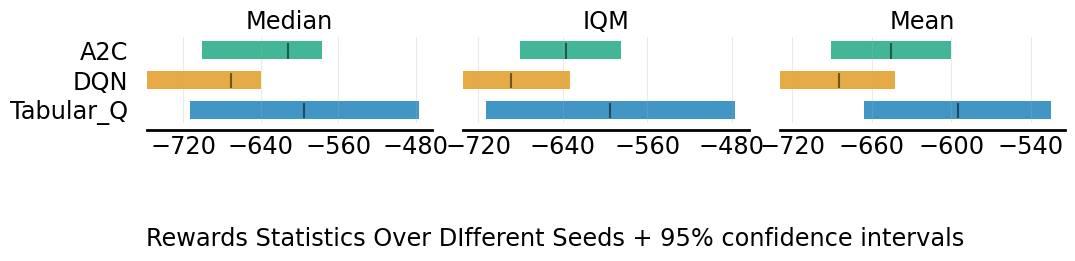

In [122]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import pandas as pd


algorithms = list(learning_curves.keys())

aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  results, aggregate_func, reps=1000)


fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean'],
  algorithms=list(results.keys()),
  xlabel='Rewards Statistics Over DIfferent Seeds + 95% confidence intervals',
  xlabel_y_coordinate=-1
  )

In [123]:
training_times

{'Tabular_Q': array([[0.01229882, 0.02328253, 0.03560233, 0.04572964, 0.05677152,
         0.06589222, 0.07505035, 0.08523726, 0.09421635, 0.10223246],
        [0.01298547, 0.02339244, 0.03316021, 0.04447174, 0.05468416,
         0.06386805, 0.07187104, 0.08209538, 0.09043837, 0.10061455]]),
 'DQN': array([[0.0586791 , 0.22625065, 0.39019322, 0.5545435 , 0.69751573,
         0.76650715, 0.83263445, 0.89479256, 0.95016026, 1.00400925],
        [0.05490828, 0.20233035, 0.34552884, 0.54066682, 0.69674659,
         0.76619601, 0.82462502, 0.88680434, 0.94378114, 0.9955399 ]]),
 'A2C': array([[0.22461057, 0.41927075, 0.59140182, 0.79062366, 0.99931669,
         1.09880447, 1.17397428, 1.25326204, 1.32139063, 1.38810086],
        [0.22140193, 0.40382934, 0.5784266 , 0.7598238 , 0.93108368,
         1.01331878, 1.09178162, 1.16277337, 1.22799706, 1.29401088]])}

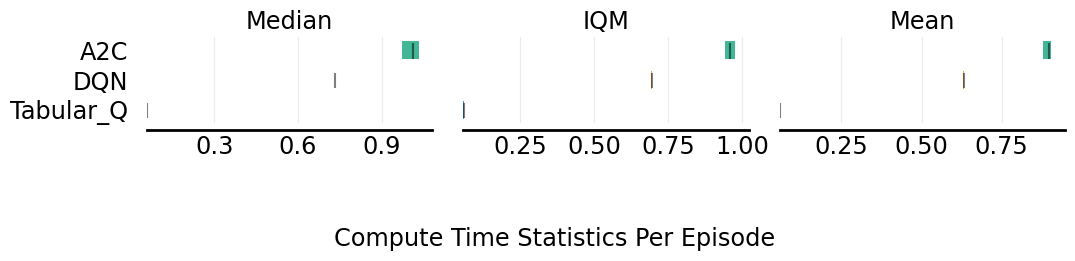

In [ ]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import pandas as pd


algorithms = list(training_times.keys())

aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  training_times, aggregate_func, reps=10)


fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean'],
  algorithms=list(training_times.keys()),
  xlabel='Compute Time Statistics Per Episode + 95% confidence intervals',
  xlabel_y_coordinate=-1
  )

Text(0.5, 1.0, '')

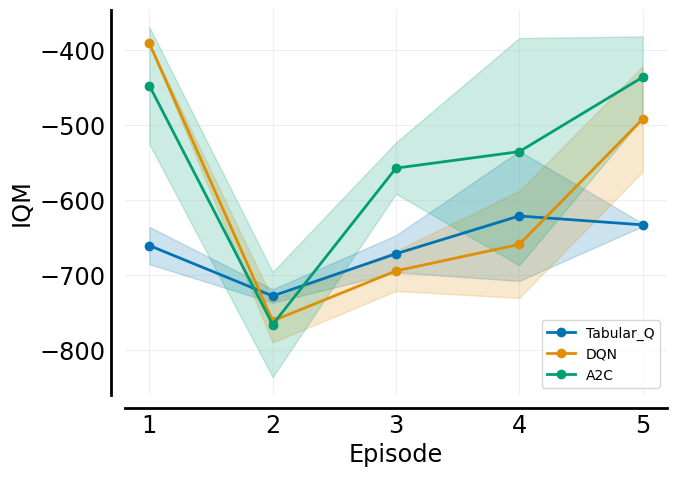

In [ ]:
## IQM learning curves (the IQM for per episode number across different seeds)
frames = np.arange(0, 5, 1)
frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in learning_curves.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  frames_scores_dict, iqm, reps=50)


ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Episode',
    ylabel='IQM')

ax.legend(loc='best')


In [2]:
import gymnasium as gym
import numpy as np
import math
import random
from env import WaterSupplyEnv
from gymnasium.spaces import MultiDiscrete
import itertools



class DiscretizedActionWrapper(gym.ActionWrapper):
    """
    Converts a continuous 3-dimensional action space (Box) into a discrete one by mapping 
    each continuous dimension into equally spaced bins. The new discrete action space 
    is a MultiDiscrete space where each element corresponds to one dimension.
    """
    def __init__(self, env, n_bins=5):
        super().__init__(env)
        self.n_bins = n_bins
        
        # Check that the original action space is a 3-dimensional Box.
        assert isinstance(self.action_space, gym.spaces.Box), "This wrapper only supports Box action spaces."
        assert self.action_space.shape == (3,), "This wrapper only supports 3-dimensional Box action spaces."
        
        # Get low and high values for each dimension
        self.low = env.action_space.low  # shape (3,)
        self.high = env.action_space.high  # shape (3,)
        
        # Define a new discrete action space using MultiDiscrete:
        # Each of the three dimensions is discretized into n_bins discrete actions.
        self.action_space = MultiDiscrete([n_bins, n_bins, n_bins])
        
        # Precompute the mapping for each dimension:
        # Each element is a linspace mapping from the low to high for that dimension.
        self.discrete_actions = [np.linspace(low, high, n_bins) for low, high in zip(self.low, self.high)]
    
    def action(self, action):
        """
        Maps the discrete action (a vector of indices for each dimension) 
        to a continuous action.
        
        Args:
            action (array-like): A 3-dimensional vector with discrete indices.
        
        Returns:
            np.array: A continuous action of shape (3,) corresponding to the bin centers.
        """
        # Ensure action is a NumPy array
        action = np.array(action)
        continuous_action = np.array([self.discrete_actions[d][action[d]] for d in range(3)])
        return continuous_action


def copy_water_env(env):
    new_env = WaterSupplyEnv()
    new_env = DiscretizedActionWrapper(new_env)
    inner_env = env.env
    new_env.env.current_hour = inner_env.current_hour
    new_env.env.water_level = inner_env.water_level
    new_env.env.demand = inner_env.demand
    new_env.env.price_A = inner_env.price_A
    new_env.env.price_B = inner_env.price_B
    return new_env

# ------------------------------
# Environment Simulator Using the Real Environment
# ------------------------------
def env_simulator(env:WaterSupplyEnv, state, action_bin):
    """
    Uses the actual environment to simulate one high-level step.
    This requires that the environment supports state cloning and restoration.
    
    Args:
        env: Gym environment instance.
        state: The saved state (obtained via env.clone_state()).
        action_bin: The discrete high-level action (bin index).
    
    Returns:
        next_state: The new state after the action.
        reward: The reward obtained.
        done: Whether the episode terminated.
    """
    # Restore environment to the given state
    env.env.set_state(state)
    
    # Execute the high-level action (for example, using the bin index directly)
    next_state, reward, done, _ = env.step(action_bin)
    return next_state, reward, done

# ------------------------------
# MCTS Implementation (as before)
# ------------------------------
class MCTSNode:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action  # The discrete action that led to this node
        self.children = {}    # Mapping: action -> child node
        self.visits = 0
        self.total_reward = 0.0

    def uct_score(self, c_param=1.41):
        if self.visits == 0:
            return float('inf')
        q_value = self.total_reward / self.visits
        bonus = c_param * math.sqrt(math.log(self.parent.visits) / self.visits)
        return q_value + bonus

    def expand(self, available_actions, env, horizon, c_param=1.41):
        for action in available_actions:
            if action not in self.children:
                next_state, reward, done = env_simulator(env, self.state, action)
                child_node = MCTSNode(next_state, parent=self, action=action)
                child_node.total_reward = reward
                child_node.visits = 1
                self.children[action] = child_node
                return child_node
        return None

def mcts_search(root_state, env:WaterSupplyEnv, available_actions, n_iters=100, horizon=5, c_param=1.41):
    root = MCTSNode(root_state)
    simulation_env = copy_water_env(env)
    for i in range(n_iters):
        node = root
        depth = 0

        # Selection
        while node.children and depth < horizon:
            best_action = max(node.children, key=lambda a: node.children[a].uct_score(c_param))
            node = node.children[best_action]
            depth += 1
            if node.parent is None:
                break

        # Expansion
        if depth < horizon:
            child = node.expand(available_actions, env, horizon, c_param)
            if child is not None:
                node = child
                depth += 1

        # Simulation (Rollout)
        sim_reward = 0.0
        sim_state = node.state
        discount = 1.0
        for d in range(depth, horizon):
            action = random.choice(available_actions)
            sim_state, reward, done = env_simulator(simulation_env, sim_state, action)
            sim_reward += discount * reward
            discount *= 0.95  # high-level discount factor
            if done:
                break

        # Backpropagation
        total_reward = sim_reward
        while node is not None:
            node.visits += 1
            node.total_reward += total_reward
            node = node.parent

    # Choose best high-level action from root
    best_action = None
    best_avg = -float('inf')
    for action, child in root.children.items():
        avg_reward = child.total_reward / child.visits
        if avg_reward > best_avg:
            best_avg = avg_reward
            best_action = action
    return best_action

# ------------------------------
# Usage Example with Real Environment as Simulator
# ------------------------------
# Create the environment
env = WaterSupplyEnv()
env = DiscretizedActionWrapper(env, 5)

# Reset environment and clone initial state
initial_state = env.reset()

available_actions = [item for item in itertools.product(range(5), range(5), range(5))]# Assuming 10 discrete high-level actions

# Run MCTS search using the real environment as simulator
best_action = mcts_search(initial_state, env, available_actions, n_iters=100, horizon=5, c_param=1.41)

# Map the discrete bin to a representative continuous action
def continuous_from_bin(bin_index, num_bins=10, min_val=0.0, max_val=300.0):
    bin_width = (max_val - min_val) / num_bins
    return min_val + bin_width * (bin_index + 0.5)

rep_continuous_action = continuous_from_bin(np.array([best_action]), num_bins=10, min_val=0.0, max_val=300.0)

print("Best high-level action (bin index):", best_action)
print("Representative continuous action for that bin:", rep_continuous_action)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices